# Flight Cancellations in the United States
## by Maleina Bidek

## Preliminary Wrangling

In this notebook, we will be exploring a dataset that contains flight arrival and departure details for all commercial flights within the United States, including whether or not flights were cancelled or delayed and what the reason was. The data set is from the American Statistical Society and can be found [here.](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009) While the original set contains data from October 1987 to December 2008, in this analysis, we will specifically be exploring data over the one year period from January to December 2008.

*Note that while the data set's home page says that it contains records through April 2008, we have verified that it actually contains records through December 2008.*

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

The first thing we need to do is load in our dataset, which is contained in a .csv file that has been compressed. The set is quite large, so this could take a while!

In [2]:
print("Loading 2008 data...")
df_flights = pd.read_csv('data/2008.csv.bz2',compression='bz2')

print("Loading complete!")

Loading 2008 data...
Loading complete!


Next, we'll check to see if we have issues in our data that require cleaning. First, however, let's check the size of our dataset.

In [3]:
df_flights.shape

(7009728, 29)

We have over 7 million rows and 29 columns. One of the things we'll need to explore is paring down the set so that computations take less time. Let's do a quick visual check on the set first.

In [4]:
df_flights

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009723,2008,12,13,6,1002.0,959,1204.0,1150,DL,1636,...,6.0,45.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009724,2008,12,13,6,834.0,835,1021.0,1023,DL,1637,...,5.0,23.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009725,2008,12,13,6,655.0,700,856.0,856,DL,1638,...,24.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,1639,...,13.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


One of the first things that sticks out is that `Year`, `Month` and `DayofMonth` could be combined into a single date field. However, because we don't anticipate conducting a time series analysis, i.e. plotting flight information over time, it actually will be more useful to have these columns separated. This will make it easier for us to aggregate over months or days of the week, for example.

There are also a number of fields that we don't need: `DepTime`, `ArrTime`, `TailNum`, `ActualElapsedTime`, `CRSElapsedTime`, `AirTime`, `Distance`, `TaxiIn`, `TaxiOut`. We can remove these.

`CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateArrCraftDelay` are columns that are supposed to represent the amount of time spent on that particular type of delay. They are not mutually exclusive: It is possible to have an amount listed in more than one of these columns for the same flight. Note that in this report I generally refer to them as the 'delay reason' columns. Given that we already see that there are null values in some of these fields, we'll want to explore further what to do with these columns.

Because this set is quite large, we will first remove the columns that we won't be using.

In [5]:
# Remove unneeded columns
df_flights.drop(['DepTime', 'ArrTime', 'TailNum', 'ActualElapsedTime', 
                 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut'], 
                axis=1, inplace=True)

In [6]:
# Ensure that columns have been removed.
df_flights.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Let's check our data types next, noting that we'll want to reduce unnessary storage where possible.

In [7]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   CRSDepTime         int64  
 5   CRSArrTime         int64  
 6   UniqueCarrier      object 
 7   FlightNum          int64  
 8   ArrDelay           float64
 9   DepDelay           float64
 10  Origin             object 
 11  Dest               object 
 12  Cancelled          int64  
 13  CancellationCode   object 
 14  Diverted           int64  
 15  CarrierDelay       float64
 16  WeatherDelay       float64
 17  NASDelay           float64
 18  SecurityDelay      float64
 19  LateAircraftDelay  float64
dtypes: float64(7), int64(9), object(4)
memory usage: 1.0+ GB


Some data types are incorrect. `CRSDepTime` and `CRSArrTime` should be converted to time. `Diverted` and `Cancelled` appear to use 1 for yes and 0 for no and could easily be converted to the more useful Boolean type.  Before we do that let's double check that `Diverted` and `Cancelled` have only the values of 1 (yes) and 0 (no).

In [8]:
df_flights['Diverted'].value_counts()

0    6992463
1      17265
Name: Diverted, dtype: int64

In [9]:
df_flights['Cancelled'].value_counts()

0    6872294
1     137434
Name: Cancelled, dtype: int64

We can see that these two colums have no other values besides zero and one which means that they can easily be converted.

Before we can fix any of our data types, we'll need to check for nulls, as the presence of these could prevent the converstion. Due to the size of our set, this information wasn't present when we called the info() fuction. We'll have to check explicitly.

In [10]:
# Search all columns for nulls and print the number of them.
for row in df_flights.columns:
    print('{}: {}'.format(row, sum(df_flights[row].isna())))
print('Search complete!')

Year: 0
Month: 0
DayofMonth: 0
DayOfWeek: 0
CRSDepTime: 0
CRSArrTime: 0
UniqueCarrier: 0
FlightNum: 0
ArrDelay: 154699
DepDelay: 136246
Origin: 0
Dest: 0
Cancelled: 0
CancellationCode: 6872294
Diverted: 0
CarrierDelay: 5484993
WeatherDelay: 5484993
NASDelay: 5484993
SecurityDelay: 5484993
LateAircraftDelay: 5484993
Search complete!


We will need to investigate the nulls in the `ArrDelay`, `DepDelay`, `CancellationCode`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateAircraftDelay` columns.

Let's explore `ArrDelay` and `DepDelay` first.

In [11]:
# Seach for records where ArrDelay is null
df_flights[df_flights['ArrDelay'].isna()]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
178,2008,1,3,4,700,830,WN,126,NaN,NaN,LAS,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
373,2008,1,3,4,1100,1215,WN,1146,NaN,NaN,LAX,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
399,2008,1,3,4,905,1025,WN,469,NaN,NaN,LAX,SFO,1,A,0,NaN,NaN,NaN,NaN,NaN
401,2008,1,3,4,1620,1740,WN,618,NaN,NaN,LAX,SFO,1,C,0,NaN,NaN,NaN,NaN,NaN
415,2008,1,3,4,1930,2035,WN,2528,NaN,NaN,LAX,SJC,1,A,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009455,2008,12,13,6,600,815,DL,1211,NaN,NaN,LGA,CVG,1,A,0,NaN,NaN,NaN,NaN,NaN
7009464,2008,12,13,6,1930,2129,DL,1218,NaN,NaN,CVG,LGA,1,A,0,NaN,NaN,NaN,NaN,NaN
7009564,2008,12,13,6,700,1035,DL,1421,NaN,NaN,BOS,FLL,1,A,0,NaN,NaN,NaN,NaN,NaN
7009565,2008,12,13,6,1115,1432,DL,1422,NaN,NaN,FLL,BOS,1,A,0,NaN,NaN,NaN,NaN,NaN


These flights all appear to be cancellations. Let's confirm this by seeing if any nulls exist when canceled is false.

In [12]:
df_flights[(df_flights['ArrDelay'].isna()) & (df_flights['Cancelled']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1763,2008,1,3,4,915,1050,WN,1069,NaN,7.0,SAN,SMF,0,NaN,1,NaN,NaN,NaN,NaN,NaN
1911,2008,1,3,4,1900,2030,WN,2092,NaN,265.0,SFO,SAN,0,NaN,1,NaN,NaN,NaN,NaN,NaN
2651,2008,1,4,5,1905,1910,WN,1403,NaN,44.0,BOI,RNO,0,NaN,1,NaN,NaN,NaN,NaN,NaN
2726,2008,1,4,5,705,825,WN,178,NaN,32.0,BUR,SMF,0,NaN,1,NaN,NaN,NaN,NaN,NaN
3383,2008,1,4,5,930,1145,WN,2011,NaN,1.0,HOU,OAK,0,NaN,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006200,2008,12,10,3,640,859,DL,1610,NaN,34.0,JAN,ATL,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7006401,2008,12,11,4,1106,1950,DL,26,NaN,169.0,LAX,JFK,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7007034,2008,12,11,4,1520,1708,DL,1102,NaN,7.0,IAD,ATL,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7007389,2008,12,11,4,725,945,DL,1491,NaN,-8.0,LGA,MSY,0,NaN,1,NaN,NaN,NaN,NaN,NaN


OK, it looks like a number of these are also diversions. Let's check to see if there are any nulls that are not cancellations nor diversions.

In [13]:
df_flights[(df_flights['ArrDelay'].isna()) & (df_flights['Cancelled']!=1) & (df_flights['Diverted']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


No rows are returned. It appears that the `ArrDelay` column is null only in the case where the flight was cancelled or diverted, which seems correct. We can fill these with 0's to be consistent with other flights in which there was no arrival delay.

In [14]:
# Remove the nulls
df_flights['ArrDelay'].fillna(0, inplace=True)

In [15]:
# Ensure that the nulls have been removed. This should return 0.
sum(df_flights[df_flights['ArrDelay'].isna()].count())

0

Let's check the `DepDelay` column now.

In [16]:
# Seach for records where DepDelay is null
df_flights[df_flights['DepDelay'].isna()]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
178,2008,1,3,4,700,830,WN,126,0.0,NaN,LAS,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
373,2008,1,3,4,1100,1215,WN,1146,0.0,NaN,LAX,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
399,2008,1,3,4,905,1025,WN,469,0.0,NaN,LAX,SFO,1,A,0,NaN,NaN,NaN,NaN,NaN
401,2008,1,3,4,1620,1740,WN,618,0.0,NaN,LAX,SFO,1,C,0,NaN,NaN,NaN,NaN,NaN
415,2008,1,3,4,1930,2035,WN,2528,0.0,NaN,LAX,SJC,1,A,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009455,2008,12,13,6,600,815,DL,1211,0.0,NaN,LGA,CVG,1,A,0,NaN,NaN,NaN,NaN,NaN
7009464,2008,12,13,6,1930,2129,DL,1218,0.0,NaN,CVG,LGA,1,A,0,NaN,NaN,NaN,NaN,NaN
7009564,2008,12,13,6,700,1035,DL,1421,0.0,NaN,BOS,FLL,1,A,0,NaN,NaN,NaN,NaN,NaN
7009565,2008,12,13,6,1115,1432,DL,1422,0.0,NaN,FLL,BOS,1,A,0,NaN,NaN,NaN,NaN,NaN


These results are similar to what we saw the `ArrDelay` column. Let's check if these are all a result of the flight being cancelled.

In [17]:
df_flights[(df_flights['DepDelay'].isna()) & (df_flights['Cancelled']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


There are no rows returned, which means that if `DepDelay` is null, then the flight was cancelled. This makes sense. Again, we should fill these with 0's for consistency.

In [18]:
# Replace nulls with 0
df_flights['DepDelay'].fillna(0, inplace=True)

In [19]:
# Verify that the nulls have been removed. This should return 0.
sum(df_flights[df_flights['DepDelay'].isna()].count())

0

Next, let's check those nulls in the `CancellationCode` column and see if any occur if cancelled is true (i.e, its 1).

In [20]:
# Check if any nulls exist when the flight was cancelled
df_flights[(df_flights['CancellationCode'].isna()) &
          (df_flights['Cancelled'] == 1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


No, the nulls are only present when the flight has not been cancelled. We can actually leave these alone as there should be no be no cancellation code unless the flight has been cancelled. Also, since this field will not have its type changed these nulls won't be a problem.

Finally, let's check the nulls in the `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateAircraftDelay` columns. Let's check if any of these columns are null when there is an arrival or departure delay, i.e. either of the values of `DepDelay` and `ArrDelay` are positive.

In [21]:
# Check if any of the delay reason columns is null when the flight has a 
# positive number of arrival or departure delay minutes.
df_flights[((df_flights['CarrierDelay'].isna()) | 
          (df_flights['WeatherDelay'].isna()) |
          (df_flights['NASDelay'].isna()) |
          (df_flights['SecurityDelay'].isna()) |
          (df_flights['LateAircraftDelay'].isna())) & 
          ((df_flights['ArrDelay'] > 0)|
          (df_flights['DepDelay'] > 0))]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1955,2225,WN,335,-14.0,8.0,IAD,TPA,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,735,1000,WN,3231,2.0,19.0,IAD,TPA,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,620,750,WN,448,14.0,8.0,IND,BWI,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5,2008,1,3,4,1915,2110,WN,378,11.0,25.0,IND,JAX,0,NaN,0,NaN,NaN,NaN,NaN,NaN
8,2008,1,3,4,615,650,WN,11,2.0,2.0,IND,MCI,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009720,2008,12,13,6,800,1026,DL,1633,6.0,-4.0,MSY,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009722,2008,12,13,6,750,859,DL,1636,2.0,-1.0,SAV,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009723,2008,12,13,6,959,1150,DL,1636,14.0,3.0,ATL,IAD,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009726,2008,12,13,6,1240,1437,DL,1639,9.0,11.0,IAD,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Here we have a number of flights that were actually delayed but no reason was noted. It looks like all of these have arrival delays of less than 15 minutes, however. As a general rule of thumb, 15 minutes is usually considered the threshold for calling a flight delayed. Let's check if all arrival delays over 15 minutes have values in these delay reason columns.

In [22]:
# Check if there are nulls in the delay reason columns when 
# a flight has an arrival delay of at least 15 mintues
df_flights[((df_flights['CarrierDelay'].isna()) | 
          (df_flights['WeatherDelay'].isna()) |
          (df_flights['NASDelay'].isna()) |
          (df_flights['SecurityDelay'].isna()) |
          (df_flights['LateAircraftDelay'].isna())) & 
          (df_flights['ArrDelay'] >= 15)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


We can see that all flights with an arrival delay of 15 minutes or more do not have nulls in any of the delay reason columns.

Given that no delay was flagged and that these columns track the amount of minutes for each type of delay, it makes sense to fill our nulls in all of these columns with 0's.

In [23]:
# Remove nulls from each of the delay reason columns 
delay_reason_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_reason_cols:
    df_flights[col].fillna(0, inplace=True)

In [24]:
# Ensure that the columns have no more nulls. All should return 0
for col in delay_reason_cols:
    print('# of nulls for '+ col + ': {}'.format(sum(df_flights[df_flights[col].isna()].count())))

# of nulls for CarrierDelay: 0
# of nulls for WeatherDelay: 0
# of nulls for NASDelay: 0
# of nulls for SecurityDelay: 0
# of nulls for LateAircraftDelay: 0


Next, let's finally fix our data types. `Diverted` and `Cancelled` will be converted to Boolean. We'll address `CRSDepTime` and `CRSArrTime` shortly as their conversion is a bit more complicated. *(Note, we'd initially planned on reducing numeric columns from 64-bits, however, this caused overflow in our calculations during our analysis later on.)*

In [25]:
# Convert all floats and integers to 16 bit (instead of 64)
# df_flights['Year'] = df_flights['Year'].astype(np.int16)
# df_flights['Month'] = df_flights['Month'].astype(np.int16)
# df_flights['DayofMonth'] = df_flights['DayofMonth'].astype(np.int16)
# df_flights['DayOfWeek'] = df_flights['DayOfWeek'].astype(np.int16)
# df_flights['FlightNum'] = df_flights['FlightNum'].astype(np.int16)
# df_flights['ArrDelay'] = df_flights['ArrDelay'].astype(np.float16)
# df_flights['DepDelay'] = df_flights['DepDelay'].astype(np.float16)
# df_flights['CarrierDelay'] = df_flights['CarrierDelay'].astype(np.float16)
# df_flights['WeatherDelay'] = df_flights['WeatherDelay'].astype(np.float16)
# df_flights['NASDelay'] = df_flights['NASDelay'].astype(np.float16)
# df_flights['SecurityDelay'] = df_flights['SecurityDelay'].astype(np.float16)
# df_flights['LateAircraftDelay'] = df_flights['LateAircraftDelay'].astype(np.float16)

# Convert Cancelled and Diverted to boolean
df_flights['Cancelled'] = df_flights['Cancelled'].astype(bool)
df_flights['Diverted'] = df_flights['Diverted'].astype(bool)

In [26]:
# Verify that our data types have been converted
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   CRSDepTime         int64  
 5   CRSArrTime         int64  
 6   UniqueCarrier      object 
 7   FlightNum          int64  
 8   ArrDelay           float64
 9   DepDelay           float64
 10  Origin             object 
 11  Dest               object 
 12  Cancelled          bool   
 13  CancellationCode   object 
 14  Diverted           bool   
 15  CarrierDelay       float64
 16  WeatherDelay       float64
 17  NASDelay           float64
 18  SecurityDelay      float64
 19  LateAircraftDelay  float64
dtypes: bool(2), float64(7), int64(7), object(4)
memory usage: 976.0+ MB


Next, lets convert our `CRSDepTime` and `CRSArrTime` columns to dates. We'll actually convert them to the timedelta type, as this will allow us to perform calculations with them.

First, let's check the upper range of our values. If there are values of 2400 (i.e. 24:00) or greater, this could cause issues later during our analysis, since we will be looking at scheduled arrival and departure times in the context of a 24 hour period. *(Note, sometimes arrival times are given for 24:00 or more meaning that the flight arrives after midnight on the next calendar day.)*

In [27]:
df_flights['CRSDepTime'].max()

2359

In [28]:
df_flights['CRSArrTime'].max()

2400

There are flights with scheduled arrival times of 2400. We should change these to 0, since that is another way to express the same time. After that, we can finally convert our departure and arrival times, by parsing the hours and minutes and then putting them into a timedelta field.

In [29]:
# Convert values of 2400 to 0, as they both represent the same time
df_flights.loc[df_flights['CRSDepTime']==2400]=0
df_flights.loc[df_flights['CRSArrTime']==2400]=0
# Convert the columns by using floor division to extract the hour
# and mod division to extract the minutes. Both the hour and the minutes
# are converted to timedelta format and then added together to get the full time in proper format
df_flights['CRSDepTime'] = (pd.to_timedelta(df_flights['CRSDepTime']//100, unit='h') + 
                            pd.to_timedelta(df_flights['CRSDepTime']%100, unit='m'))
df_flights['CRSArrTime'] = (pd.to_timedelta(df_flights['CRSArrTime']//100, unit='h') + 
                            pd.to_timedelta(df_flights['CRSArrTime']%100, unit='m'))

In [30]:
# Verify the data types are correct
df_flights[['CRSDepTime', 'CRSArrTime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 2 columns):
 #   Column      Dtype          
---  ------      -----          
 0   CRSDepTime  timedelta64[ns]
 1   CRSArrTime  timedelta64[ns]
dtypes: timedelta64[ns](2)
memory usage: 107.0 MB


Finally, let's check for duplicates in our dataset.

In [31]:
sum(df_flights.duplicated())

550

Let's remove these from our set. 

In [32]:
# Drop duplicates
df_flights.drop_duplicates(inplace=True)

In [33]:
# Check that the number of duplicates is now 0.
sum(df_flights.duplicated())

0

Let's take a quick look at our stats.

In [34]:
df_flights.describe()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7009178,7009178,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06
mean,2.008000e+03,6.375266e+00,1.572803e+01,3.924172e+00,0 days 13:26:18.898116155,0 days 15:08:25.511807518,2.223996e+03,7.988796e+00,9.778484e+00,3.430955e+00,6.610928e-01,3.733884e+00,1.630947e-02,4.518396e+00
std,7.584556e-01,3.406754e+00,8.797018e+00,1.988259e+00,0 days 04:39:15.752689727,0 days 04:49:46.375306253,1.961629e+03,3.809504e+01,3.499371e+01,1.980210e+01,9.182250e+00,1.647554e+01,8.577830e-01,2.021694e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:00,0 days 00:00:00,0.000000e+00,-5.190000e+02,-5.340000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.008000e+03,3.000000e+00,8.000000e+00,2.000000e+00,0 days 09:25:00,0 days 11:15:00,6.220000e+02,-1.000000e+01,-4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.008000e+03,6.000000e+00,1.600000e+01,4.000000e+00,0 days 13:20:00,0 days 15:17:00,1.571000e+03,-2.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.008000e+03,9.000000e+00,2.300000e+01,6.000000e+00,0 days 17:15:00,0 days 19:07:00,3.517000e+03,1.100000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.008000e+03,1.200000e+01,3.100000e+01,7.000000e+00,0 days 23:59:00,0 days 23:59:00,9.743000e+03,2.461000e+03,2.467000e+03,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03


Let's also get a final count of rows and columns.

In [35]:
df_flights.shape

(7009178, 20)

### What is the structure of your dataset?

As we can see above, our cleaned dataset contains 7,009,178 rows and 20 columns. Most of columns are of a numeric type: `Year`, `Month`, `DayofMonth`, `DayOfWeek` and `FlightNum` are discrete integers, the first four being ordinal. `ArrDelay`, `DepDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay` are all continuous float types.

`UniqueCarrier`, `Origin`, `Dest` and `CancellationCode` are categorical text fields. `Cancelled` and `Diverted` have been converted to boolean type. Finally, `CRSDepTime` and `CRSArrTime` have been converted to time types (specifically, timedelta type).

### What is/are the main feature(s) of interest in your dataset?

We're going to be exploring flight cancellations and delays and their reasons. In particular, are there patterns by time of day, time of year, origin and destination? Are particular carriers or flights particularly prone to issues?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

All of the columns that we've retainted will be of interest, but these in particular: 
- `Month`
- `DayOfWeek`
- `CRSDepTime`
- `CRSArrTime`
- `DepDelay`
- `ArrDelay`
- `UniqueCarrier`
- `FlightNum`
- `Origin`
- `Dest`
- `Cancelled`
- `CancellationCode`

## Univariate Exploration

We will now explore our dataset using various plots.

First, let's look at the distribution of our set of flights over month, day of month and day of week. We want to see how the flights in our dataset are distributed with respect to time of year, days within the month and day of week.  We would expeact that they should be evenly distributed, i.e. there are roughly the same number in each category. If not, that could mean that our dataset has gaps or is incomplete.

Let's start by looking at how our flights are distributed by month.

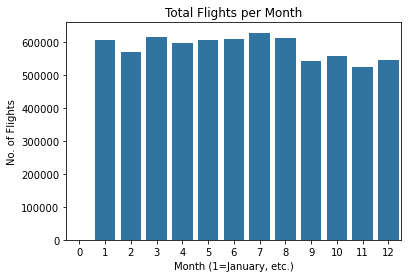

In [36]:
# Select a base color
base_color = sb.color_palette()[0]

# Plot total flights over each month
ax=sb.countplot(data=df_flights, x='Month', color=base_color)
plt.title('Total Flights per Month')
plt.xlabel('Month (1=January, etc.)')
plt.ylabel('No. of Flights');

We have an issue! It appears that there's one or more records that has `Month` set to 0. Recall that this column should be between 1 and 12. Let's take a look.

In [37]:
# Check if there exist any rows with Month set to 0.
df_flights[df_flights['Month']==0]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
454781,0,0,0,0,0 days,0 days,0,0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


This clearly looks like an extraneous row that should be removed. Let's go ahead and do that.

In [38]:
# Remove the row with Month = 0
df_flights = df_flights[df_flights['Month']!=0]

In [39]:
# Double check that the month has been removed
df_flights[df_flights['Month']==0]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


Now that that has been taken care of, let's take another look at how flights are distributed by Month in our dataset.

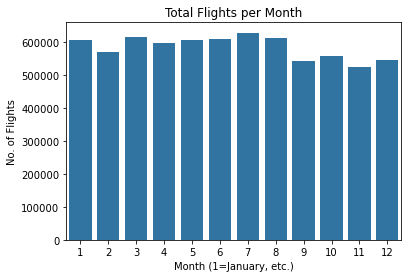

In [40]:
# Plot total flights over each month
ax=sb.countplot(data=df_flights, x='Month', color=base_color)
plt.title('Total Flights per Month')
plt.xlabel('Month (1=January, etc.)')
plt.ylabel('No. of Flights');

While there are some slight variations, the number of flights per month is roughly in the same range from 500k to 500k. Next, let's look at how flights are distributed per calendar day.

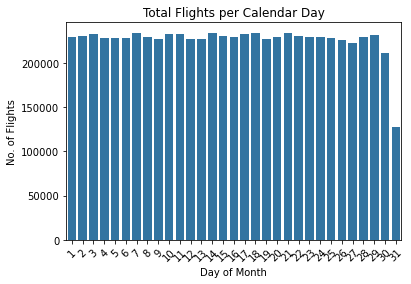

In [41]:
# Plot total flights over each calendar day
ax=sb.countplot(data=df_flights, x='DayofMonth', color=base_color)
plt.title('Total Flights per Calendar Day')
plt.xlabel('Day of Month')
plt.ylabel('No. of Flights')
plt.xticks(rotation=45);

We would expect that the number of flights would be roughly the same for each calendar day. But here we see substantially less for the 31st. This is actually expected due to there being five months every year with 30 days or less. 

As we saw from our plot above the number of flights per month is roughly the same, so our data set looks pretty evenly distributed with respect to dates. There aren't any patterns such as missing months or calendar days, for example. 

Next, let's look at our distribution for days of the week.

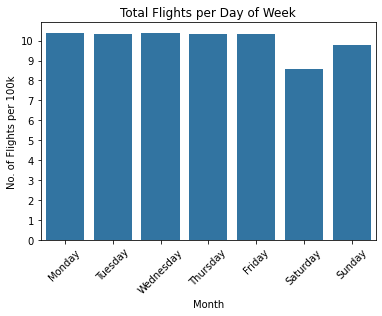

In [42]:
# Set up our axes labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ticks = np.arange(0,1100000,100000)
labels = ['{}'.format(v) for v in np.arange(11)]

# Plot total flights over each day of the week
ax=sb.countplot(data=df_flights, x='DayOfWeek', color=base_color)
plt.title('Total Flights per Day of Week')
plt.xlabel('Month')
plt.xticks(np.arange(0,7,1), days_of_week, rotation=45)
plt.ylabel('No. of Flights per 100k')
plt.yticks(ticks, labels);

We can see from the above that there are slightly fewer flights on the weekends, Saturdays in particular. Again, this is to be expected, as business travel makes up a large proportion of air travel.

Next, let's explore the distribution of our departure and arrival times.

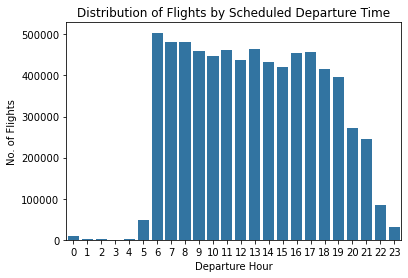

In [43]:
ax=sb.countplot(data=df_flights, x=df_flights['CRSDepTime'].astype('timedelta64[h]'), color=base_color)
plt.title('Distribution of Flights by Scheduled Departure Time')
plt.ylabel('No. of Flights')
plt.xlabel('Departure Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

We can see that there seem to be more flights scheduled earlier in the day from 6am onward, dropping off slightly until around 8pm when they start to decrease significantly. From midnight to 6am, there are very few scheduled flights.

Let's check scheduled arrival times next.

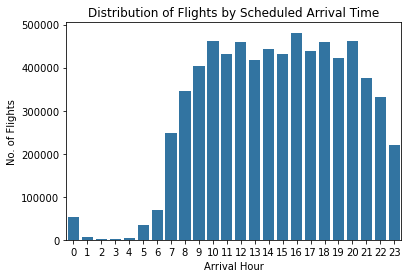

In [44]:
ax=sb.countplot(data=df_flights, x=df_flights['CRSArrTime'].astype('timedelta64[h]'), color=base_color)
plt.title('Distribution of Flights by Scheduled Arrival Time')
plt.ylabel('No. of Flights')
plt.xlabel('Arrival Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

Contrary to scheduled departure times, arrival times seem more normally distributed, increasing from 5am until midmorning, when they remain relatively consistent until they start dropping off around 9pm.

In either case, there don't appear to be any suprises. One would expect that there would be fewer arrivals and departures in the early morning and late evening hours.

Now that we have looked at the distribution of our flights over time, let's explore origins and destinations. Because we're looking at flights in the United States, we expect that there are a large number of both. Let's check our value counts to see how many we're talking about.

In [45]:
df_flights['Origin'].value_counts()

ATL    414511
ORD    350380
DFW    281279
DEN    241441
LAX    215608
        ...  
BJI        74
INL        72
TUP        10
PIR         5
PUB         2
Name: Origin, Length: 303, dtype: int64

In [46]:
df_flights['Dest'].value_counts()

ATL    414521
ORD    350452
DFW    281400
DEN    241462
LAX    215685
        ...  
INL        72
TUP         9
PIR         5
CYS         2
OGD         2
Name: Dest, Length: 304, dtype: int64

We've got over 300 destinations and orgins in our dataset. Let's graph the top 20 of each.

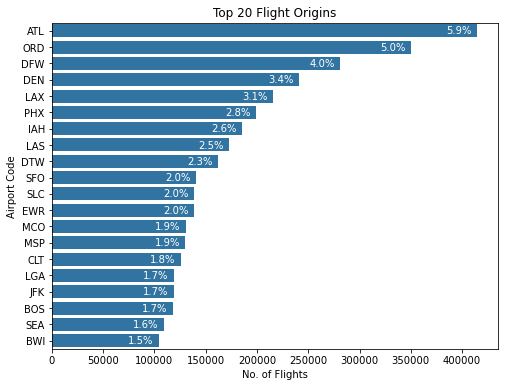

In [47]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))
# Get the top 20 origins
top_origins = df_flights['Origin'].value_counts().head(20)

# Plot total flights over the top 20 origins
sb.barplot(x=top_origins.values, y=top_origins.index, color=base_color)
plt.title('Top 20 Flight Origins')
plt.ylabel('Airport Code')
plt.xlabel('No. of Flights');

# Calculate count and totals for proportion percentage
type_counts = df_flights['Origin'].value_counts()
n_origins = df_flights['Origin'].value_counts().sum()
# Print the proportion text on the bars
for i in range (20):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_origins)
    # Print percentage at end of bar
    plt.text(count-30000, i, pct_string, va='center', color='w')

Atlanta has the most flights in our set, with almost 6% of the total, followed by Chicago O'Hare with 5% of the total.

Let's look at the top 20 destinations next.

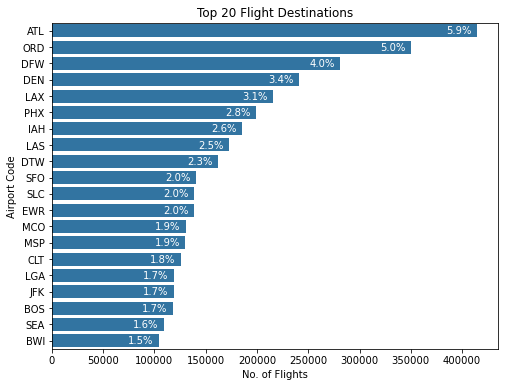

In [48]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))
# Get the top 20 destinations
top_dests = df_flights['Dest'].value_counts().head(20)
# Plot total flights over the top 20 destinations
sb.barplot(x=top_dests.values, y=top_dests.index, color=base_color)
plt.title('Top 20 Flight Destinations')
plt.ylabel('Airport Code')
plt.xlabel('No. of Flights');

# Calculate count and totals for proportion percentage
type_counts = df_flights['Dest'].value_counts()
n_dests = df_flights['Dest'].value_counts().sum()
# Print the proportion text on the bars
for i in range (20):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_dests)
    # Print percentage at end of bar
    plt.text(count-30000, i, pct_string, va='center', color='w')

This is interesting. They look virtually identical. (I even had to double-check my code!) However, if we print the value counts driving each graph, we'll see why.

In [49]:
df_flights['Origin'].value_counts()[0:20]

ATL    414511
ORD    350380
DFW    281279
DEN    241441
LAX    215608
PHX    199408
IAH    185169
LAS    172875
DTW    161890
SFO    140587
SLC    139088
EWR    138506
MCO    130872
MSP    130239
CLT    126042
LGA    119134
JFK    118804
BOS    117908
SEA    109069
BWI    104073
Name: Origin, dtype: int64

In [50]:
df_flights['Dest'].value_counts()[0:20]

ATL    414521
ORD    350452
DFW    281400
DEN    241462
LAX    215685
PHX    199416
IAH    185158
LAS    172870
DTW    161932
SFO    140579
SLC    139077
EWR    138491
MCO    130859
MSP    130248
CLT    126029
LGA    119101
JFK    118802
BOS    117943
SEA    109075
BWI    104068
Name: Dest, dtype: int64

As we can see, the ordering of the top twenty Origins and Destinations is identical and the counts for each airport are also almost identical. Thus, our graphs both look the same. This does make sense if you consider that most routes would likely be designed for a round-trip itinerary.

Next, let's explore carriers. Specifically, let's look at the top 10.

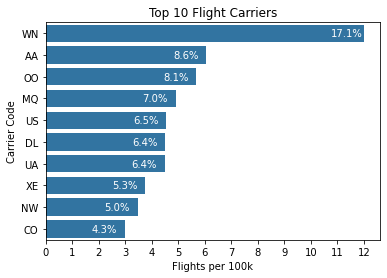

In [51]:
# Plot total flights over the top 10 carriers
ticks = np.arange(0,1300000,100000)
labels = ['{}'.format(v) for v in np.arange(13)]
top_carriers = df_flights['UniqueCarrier'].value_counts().head(10)
sb.barplot(x=top_carriers.values, y=top_carriers.index, color=base_color)
plt.title('Top 10 Flight Carriers')
plt.ylabel('Carrier Code')
plt.xlabel('Flights per 100k')
plt.xticks(ticks, labels);

# Calculate count and totals for proportion percentage
type_counts = df_flights['UniqueCarrier'].value_counts()
n_carriers = df_flights['UniqueCarrier'].value_counts().sum()
# Print the proportion text on the bars
for i in range (10):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_carriers)
    # Print percentage at end of bar
    plt.text(count-125000, i, pct_string, va='center', color='w')

We see that Southwest Airlines (WN) had the highest percentage of flights at 17.1%, followed by American (AA) with 8.6%.

Next, let's explore how cancellations and cancellation codes are distributed. We'll start by looking at the overall percentage of flights that get cancelled.

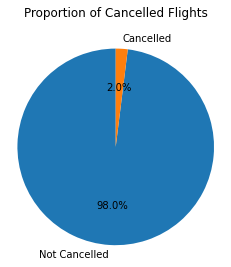

In [52]:
# Sort counts of cancelled vs. non-called flights in prep for plotting
sorted_cancel_counts = df_flights['Cancelled'].value_counts()
# Plot pie chart of proportion of cancelled flights
plt.pie(sorted_cancel_counts, labels = ['Not Cancelled', 'Cancelled'], startangle = 90, autopct='%1.1f%%');
plt.axis('square')
plt.title('Proportion of Cancelled Flights\n');

As we can see above, the overall proportion of flights that were cancelled is actually quite small: 2%. Next, let's look at the reasons that these flights were cancelled.

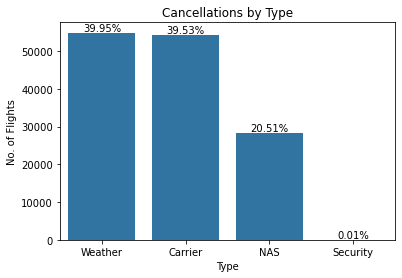

In [53]:
# Plot total flights over each month
code_order = df_flights['CancellationCode'].value_counts().index[0:4]
labels = code_order.map({'A': 'Carrier', 'B': 'Weather', 'C': 'NAS', 'D': 'Security',})
ax=sb.countplot(data=df_flights, x='CancellationCode', color=base_color, order=code_order)
plt.title('Cancellations by Type')
plt.xlabel('Type')
plt.xticks(ticks=ax.get_xticks(),labels=labels)
plt.ylabel('No. of Flights')

# Get total count of non-null values in order to calculate proportions    
n_can_type = df_flights['CancellationCode'].value_counts()[0:4].sum()
# Plot the proportion percentage above each bar
for p in ax.patches:
    height = p.get_height()
    pct_string = '{:0.2f}%'.format(100*height/n_can_type)
    ax.text(p.get_x()+ p.get_width()/2.0, height +500, pct_string, ha="center");

The first thing that stands out is that there are relatively few cancellations due to security reasons. Also, Weather and Carrier cancellations we almost equal at 39.95% and 39.53% respectively.

Next, let's look at our columns related to delays. Let's start with our departure delays.

In [54]:
# Get mins and max in order to plot histogram
df_flights['DepDelay'].describe()

count    7.009177e+06
mean     9.778485e+00
std      3.499371e+01
min     -5.340000e+02
25%     -4.000000e+00
50%     -1.000000e+00
75%      8.000000e+00
max      2.467000e+03
Name: DepDelay, dtype: float64

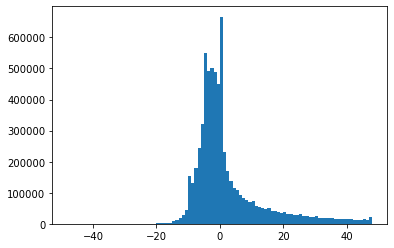

In [56]:
#Plot histogram of all departure delay times
bins = np.arange(-48, 48+1, 1)
plt.hist(data = df_flights, x = 'DepDelay', bins = bins);

If you recall both our departure and arrival delay columns can contain negative values. Negatives essentially mean that a flight either left or arrived early. If we plot out all values of the departure delay column, as above, we can see that it is roughly normal with a right tail. As to be expected, there is a spike a 0. Recall that we filled our nulls with 0's, so this seems correct.

However, we are not necessarily interested in negative delays, but positive ones, i.e. flights that either left late or arrived late. Let's plot these on both linear and logarithmic scales.

In [57]:
# Function to plot positive values of our delay columns
# in two histograms. The first on a linear and the second on
# a logarithmic scale
def plot_pos_delays(col):
    # Set our figure size
    plt.figure(figsize = [20, 5])

    #Plot histogram of all positive departure delay times
    plt.subplot(1, 2, 1) 
    bins = np.arange(1, 48+1, 1)
    plt.hist(data = df_flights, x = col, bins = bins)
    plt.title('Distribution of positive {}'.format(col))
    plt.ylabel('# of Flights')
    plt.xlabel('Delay in minutes');

    #Plot histogram of all positive departure delay times on log scale
    plt.subplot(1, 2, 2) 
    bins = 10 ** np.arange(0.1, 48+0.1, 0.1)
    ticks = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    labels = ['{}'.format(v) for v in ticks]
    plt.hist(data = df_flights, x = col, bins = bins)
    plt.xscale('log')
    plt.xlim(0.1,1000)
    plt.title('Distribution of positive {}'.format(col))
    plt.ylabel('# of Flights')
    plt.xlabel('Delay in minutes (log scale)')
    plt.xticks(ticks, labels);

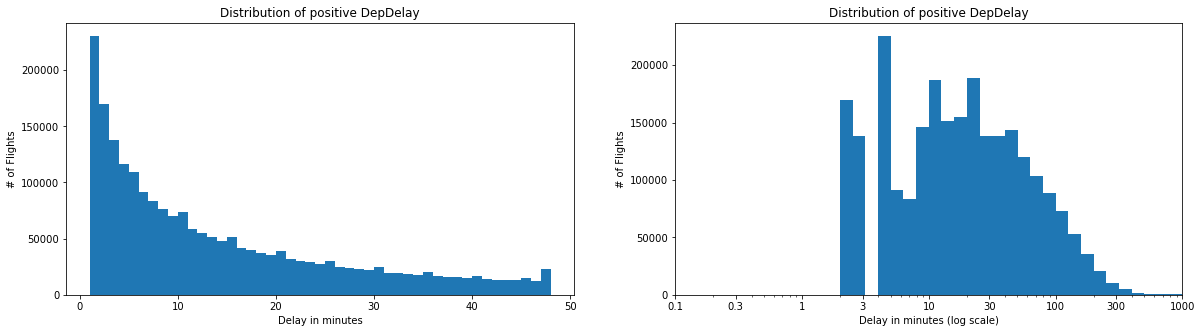

In [58]:
plot_pos_delays('DepDelay')

We can see that when we transform our scale to logaritmic what was previously a long tail now appears to be roughtly normally distributed. There are still a high number of depays of less than three minutes. Most airlines don't consider a flight to be delayed until it is more than 15 minutes late, so these aren't the types of values that we'll be focused on in our analysis.

Next, we'll look at our arrival delays.

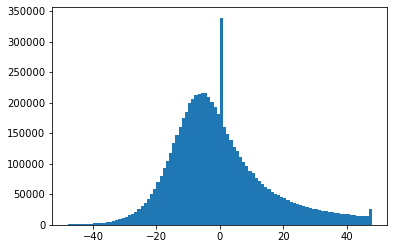

In [61]:
#Plot histogram of all arrival delay times
bins = np.arange(-48, 48+1, 1)
plt.hist(data = df_flights, x = 'ArrDelay', bins = bins);

Again, for the full set of values, we see a distribution that is roughly normal, with a long right tail and a spike at 0. Let's plot our positive values next.

In [59]:
# Get mins and max in order to plot histogram
df_flights['ArrDelay'].describe()

count    7.009177e+06
mean     7.988797e+00
std      3.809505e+01
min     -5.190000e+02
25%     -1.000000e+01
50%     -2.000000e+00
75%      1.100000e+01
max      2.461000e+03
Name: ArrDelay, dtype: float64

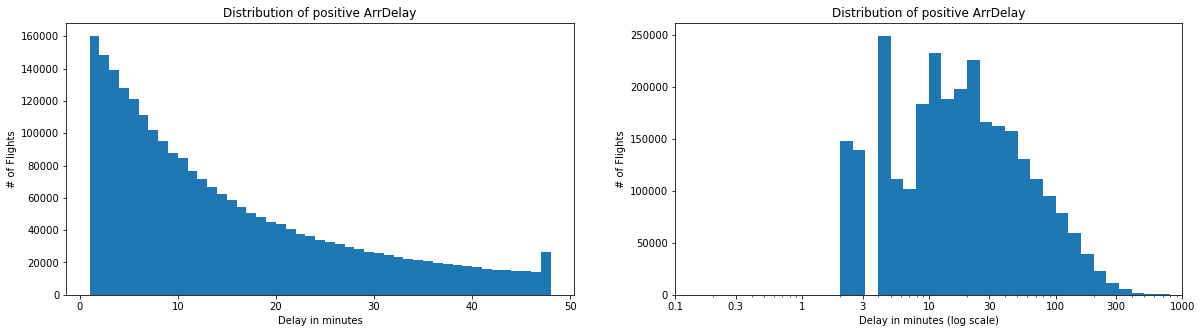

In [62]:
plot_pos_delays('ArrDelay')

Our results are similar to those for the departure delay column. The plot using a logrithmic scale is roughly normal. Again, we won't be consiered too much with "minor" delays less than 15 minutes.

Next, let's look at our five delay "reason" columns.

In [119]:
# Get our stats for each column to contruct our plots
df_flights[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].describe()

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7.009177e+06,7.009177e+06,7.009177e+06,7.009177e+06,7.009177e+06
mean,3.430955e+00,6.610929e-01,3.733884e+00,1.630948e-02,4.518397e+00
std,1.980210e+01,9.182250e+00,1.647554e+01,8.577830e-01,2.021695e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03


Here we can see that these columns don't have negative values. These delay types weren't declared unless there was a positive departure or arrival delay. Let's plot histograms with linear and logaritmic scales for each.

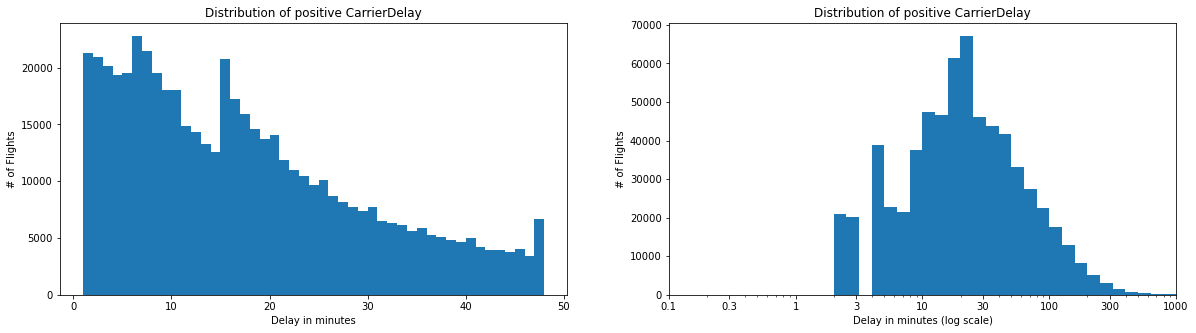

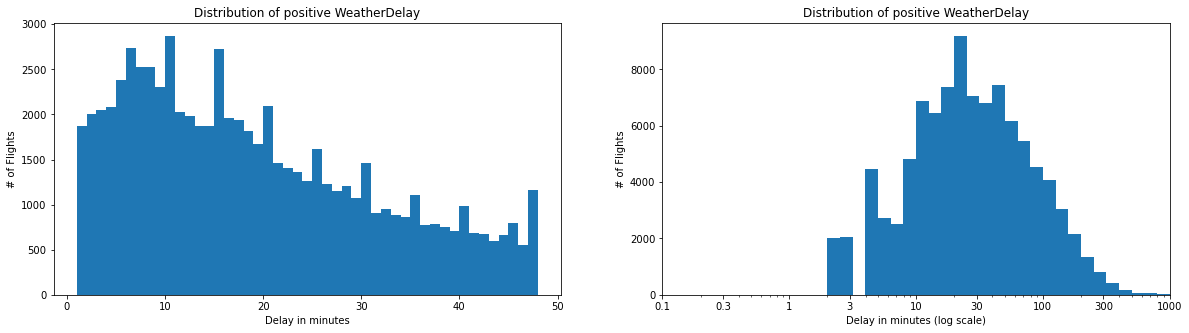

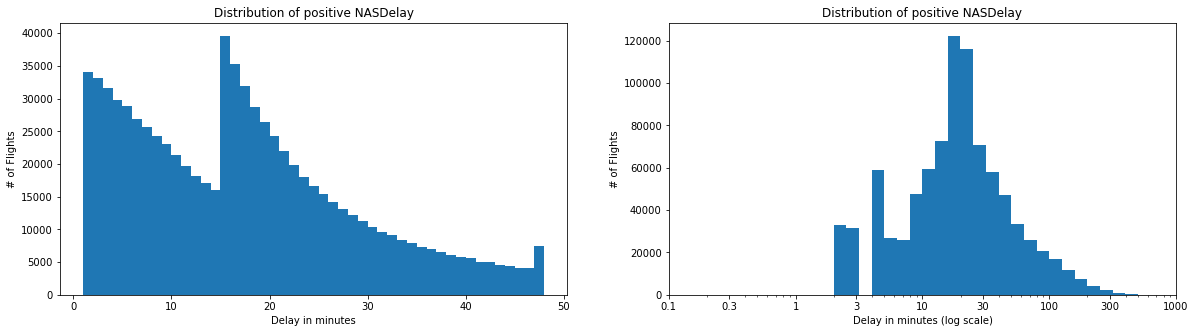

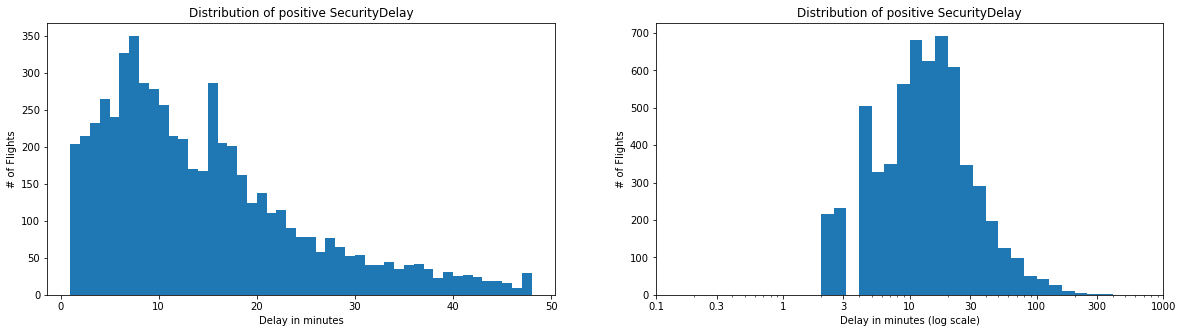

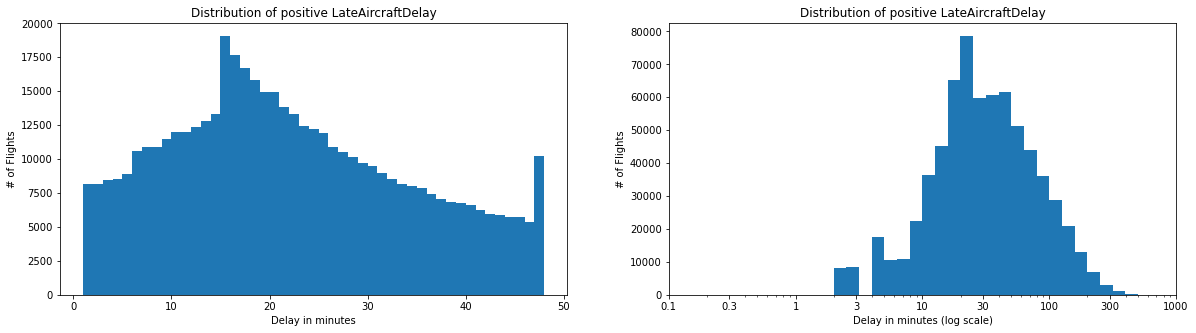

In [64]:
delay_types = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for i in range(len(delay_types)):
    plot_pos_delays(delay_types[i]);

All of them are right skewed when plotted on a linear scale and all of them are roughly normal when plotted on a logarithmic scale. The NASDelay linear plot has an interesting saw tooth pattern that has a peak at about the 15 minute mark. Interestingly, this is right at the threshold of when most flights are technically considered delayed.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The flights in our set are quite evenly distributed across time (i.e. months, days of month, days of week). Departure and arrival times were about what one would expect: More departures from 6am to 8pm, gradually tapering off throughout the day, with the fewest from the late evening to the early morning. Arrival times were similar, although they increased gradually over the morning hours, were steady over the daytime hours, until gradually tapering off in the evening. This actually makes sense, as flights are scheduled so that they arrive at destinations throughout the day, as opposed to in the wee hours of the morning, for example. 

If any of these results had not been what we would expect, then it would have raised the question as to whether or not we had a complete set of data for our time period.

In terms of flight cancellations, we saw that overall, cancellations are relatively rare, making up only 2% of the data in our set. Also, the number of cancellations due to security reasons was extremely low (0.01%) as compared to the other three types.

Arrival and departure delays were normally distributed when all values were plotted (i.e. positive and negative). However, as we are interested in positive delays, i.e. flights that are late, if we plot these we notice that they are right skewed. In order to explore these further, we performed logarithmic transformations on all of our delay columns (`ArrDelay`, `DepDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`).

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The distribution of cancellations by type is of note, especially that there is a near equal percentage of weather and carrier related cancellations. According to the [Bureau of Transportation Statistics](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations), carrier related cancellations are when a cancellation "was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.)" I would have assumed that weather cancellations would be more prevalent. 

Another surprise was that the graphs for the top 20 airports for origins and destinations were virtually identical, including the proportions of each. As noted above, however, after some reflection this isn't necessarily all that surprising as most flights are likely scheduled with round-trip travel in mind.

In terms of tidiness issues, most issues were dealt with in the wrangling phase. We did, however, have to remove one extraneous record that contained zeros for every column, which was discovered when plotting our distribution of months.

## Bivariate Exploration

Next, let's explore how our features relate to one another. We're particularly intersted in how cancellations and delays relate to each of the following:

- `Month`
- `DayOfWeek`
- `CRSDepTime`
- `UniqueCarrier`
- `Origin`

### Cancelations

Let's start by looking at cancellations per day of the week. Is there any day that stands out as being particularly cancellation prone?

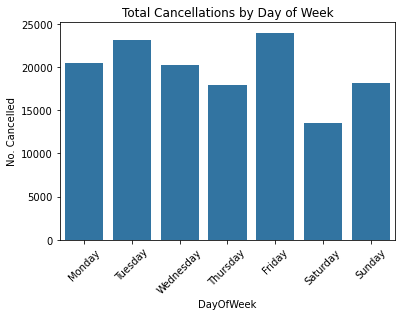

In [65]:
# Plot total number of cancellations by day of week
sb.barplot(x=df_flights.groupby('DayOfWeek')['Cancelled'].sum().index,
           y=df_flights.groupby('DayOfWeek')['Cancelled'].sum(),
           color=base_color)
plt.title('Total Cancellations by Day of Week')
plt.ylabel('No. Cancelled')
plt.xticks(np.arange(0,7,1), days_of_week, rotation=45);

We see that the number of cancellations is highest on Friday and lowest on Saturday. However, what's important to remember here is the distribution of our number of flights per week. If you recall, flight numbers were pretty consistent from Monday to Friday, lower on Saturday, and almost back to back to the weekday level on Sunday. Thus the lower count of cancellations on Saturday could be because there are fewer flights on Saturdays.

Let's try plotting the percentage of cancellations per day. That will take into account the differing number of total flights per day.

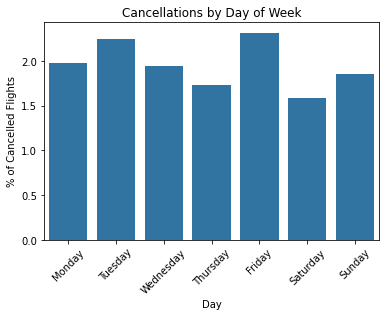

In [81]:
# Get total # of cancellations and total number of flights per day
cancelled_by_day = df_flights.groupby('DayOfWeek')['Cancelled'].sum()
total_by_day = df_flights.groupby('DayOfWeek')['Cancelled'].count()

# Plot total number of cancellations by day of week
sb.barplot(x=cancelled_by_day.index,
           y=100*cancelled_by_day/total_by_day,
           color=base_color)
plt.title('Cancellations by Day of Week')
plt.ylabel('% of Cancelled Flights')
plt.xlabel('Day')
plt.xticks(np.arange(0,7,1), days_of_week, rotation=45);

While it looks similar to the plot of total cancellations per day, there are some subtle differences. This time it is clear that Saturday has the fewest cancellations per total number of flights at about 1.5%, followed by Thursday. Friday and Tuesday have the highest proportion of cancellations, at over 2% each.

Next let's take a look at the types of cancellations per day.

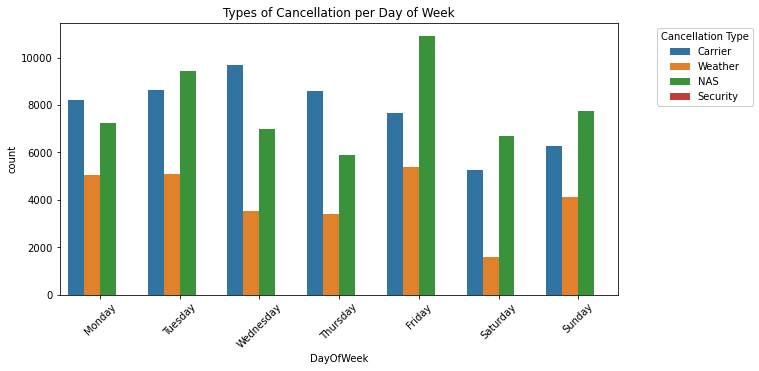

In [67]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(10,5))
#Plot the types of cancellations per day of week
ax=sb.countplot(data = df_flights, x = 'DayOfWeek', hue = 'CancellationCode')
ax.legend((['Carrier', 'Weather', 'NAS', 'Security']), loc = 1, bbox_to_anchor = (1.25, 1.0),framealpha = 1, title='Cancellation Type')
#ax.set(xlim=(0.25, 12.75))
plt.title('Types of Cancellation per Day of Week')
plt.xticks(np.arange(0,7,1), days_of_week, rotation=45);

There doesn't appear to be many obvious patterns here. We can see that carrier cancellations slowly rise from Monday to Wednesday, when they peak, continuing to drop until they reach a low on Saturday, then they start rising on Sunday again. We also see that Weather cancellations are consistenly smaller than Carrier and NAS delays.

Next let's look at cancellations by months.

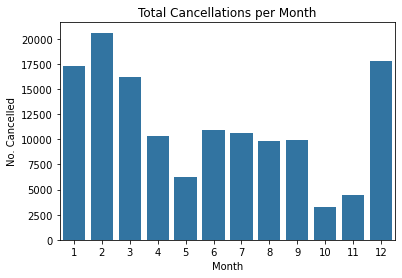

In [72]:
#Plot total cancellations by Month
sb.barplot(x=df_flights.groupby('Month')['Cancelled'].sum().index,
           y=df_flights.groupby('Month')['Cancelled'].sum(),
           color=base_color)

plt.title('Total Cancellations per Month')
plt.ylabel('No. Cancelled');

As we can see, cancellations are higher in the winter months. They're the highest in February, the month with the fewest days. October, a month with 31 days, actually has the fewest number of cancellations. Could this trend be a result of weather? Let's plot cancellation types per month to see if this is indeed the case.

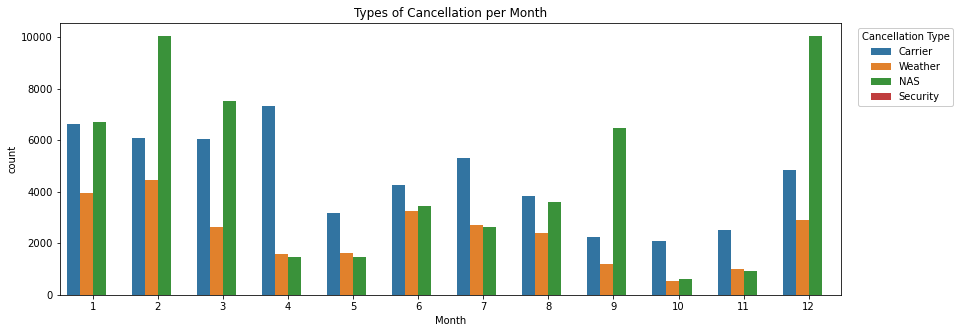

In [73]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(14,5))
#Plot the types of cancellation by month
ax=sb.countplot(data = df_flights, x = 'Month', hue = 'CancellationCode')
ax.legend((['Carrier', 'Weather', 'NAS', 'Security']), loc = 1, bbox_to_anchor = (1.15, 1.0), framealpha = 1, title='Cancellation Type')
#ax.set(xlim=(0.25, 12.75))
plt.title('Types of Cancellation per Month');

Here's where we need to be very careful as to how we interpret the cancellation codes. According to the [Bureau of Transportation Statistics](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations), the "Weather" cancellation code is used when "significant meteorological conditions (actual or forecasted) that, **in the judgment of the carrier,** delays or prevents the operation of a flight such as tornado, blizzard or hurricane." However, cancellations labeled as "NAS" (which stands for National Aviation System) can also be for weather (among other reasons, such as air traffic). The difference is that these cancellations were not made by the carriers, but instead by federal aviation authorities. So it is very possible that the higher number of cancellations in the winter is due to weather, but we'd need more drill down on the specific reason for the NAS cancellation being assigned to a particular flight.

Let's explore cancellations by scheduled departure time next.

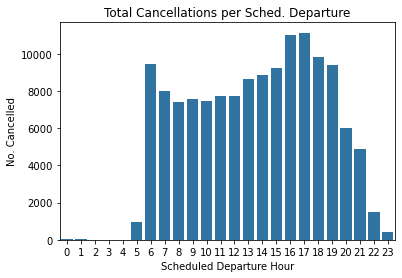

In [78]:
# Plot cancellations by scheduled departure time
ax=sb.barplot(x=df_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['Cancelled'].sum().index,
           y=df_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['Cancelled'].sum(),
           color=base_color)

plt.title('Total Cancellations per Sched. Departure')
plt.ylabel('No. Cancelled')
plt.xlabel('Scheduled Departure Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

Here we can see that ther are clearly more cancellations for departures between 4pm and 6pm. Let's check the cancellation type to see if that tells us more.

Let's normalize this by dividing by the total number of scheduled departures, just to ensure that we take into account the variation in the number of departures per time.

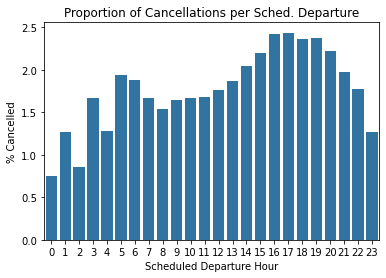

In [77]:
# Calculate total cancellations and total flights per hour
can_by_hr = df_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['Cancelled'].sum()
tot_by_hr = df_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['Cancelled'].count()

# Plot cancellations by scheduled departure time
ax=sb.barplot(x=can_by_hr.index,
           y=100*can_by_hr/tot_by_hr,
           color=base_color)

plt.title('Proportion of Cancellations per Sched. Departure')
plt.ylabel('% Cancelled')
plt.xlabel('Scheduled Departure Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

Now this is interesting. It almost looks bimodal. In fact, there appears to be fewer cancellations for flights departing between 7am and noon, then for flights that were scheduled between 5am to 7am. Also, there were more cancellations for departures around 3am then there were for departures around 11pm.  These weren't evident when we only plotted by totals.

Let's next look at the types of cancellations by hour.

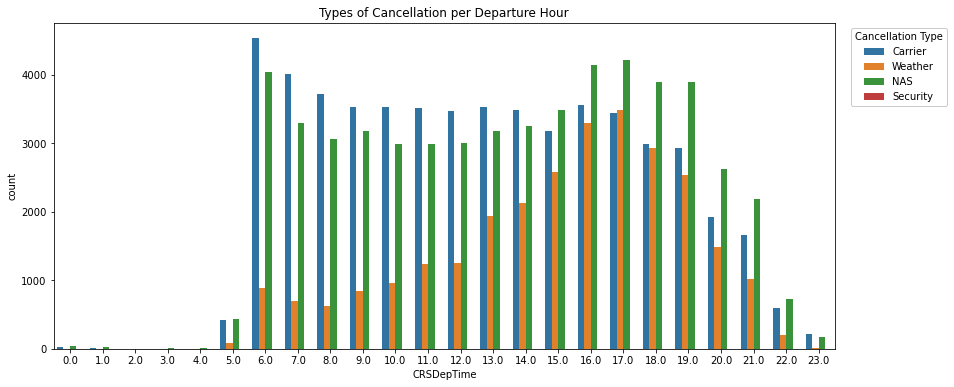

In [81]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(14,6))
#Plot the cancellation types by departure hour
ax=sb.countplot(data = df_flights, x = df_flights['CRSDepTime'].astype('timedelta64[h]'), hue = 'CancellationCode')
ax.legend((['Carrier', 'Weather', 'NAS', 'Security']), loc = 1, bbox_to_anchor = (1.15, 1.0), framealpha = 1, title='Cancellation Type')
#ax.set(xlim=(0.25, 12.75))
plt.title('Types of Cancellation per Departure Hour');

This is also interesting. While carrier cancellations predominate in the morning, by afternoon NAS cancellations are the most common type, as carrier cancellations gradually drop off. Weather cancellations seem to follow a normal distribution with a long left tail, pealing at around 5pm.

So why doesn't the Weather type follow the same pattern as the other two? It could be that there is a cascading effect. Weather delays and cancellations can impact large portions of the country at once and other types of cancellations may be more localized. We would need to do further analysis with more data to confirm this, however.

Next let's explore cancellations by carrier. Are there any that are more or less prone to cancellations?

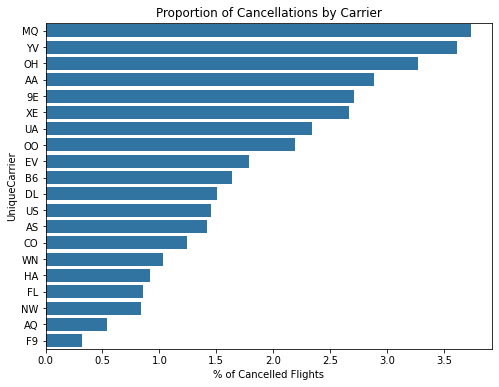

In [125]:
# Get total # of cancellations and total number of flights per day
cancelled_by_carr = df_flights.groupby('UniqueCarrier')['Cancelled'].sum()
total_by_carr = df_flights.groupby('UniqueCarrier')['Cancelled'].count()
# Calculate and sort proportion of cancellations by carrier
prop_can_by_carr = 100*cancelled_by_carr/total_by_carr
sorted_props = prop_can_by_carr.sort_values(ascending=False)
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))

# Plot total number of cancellations by carrier
sb.barplot(y=sorted_props.index,
           x=sorted_props,
           color=base_color)
plt.title('Proportion of Cancellations by Carrier')
plt.xlabel('% of Cancelled Flights');

Smaller regional airlines Envoy Air (MQ) and Mesa Airlines (YV) had the largest proportion of cancellations. Large airlines such as American (AA) and United (UA) were in the top half. Discount airline Southwest (WN) and the former major airline Northwest (NW) were in the bottom rang. Smaller regional carrier Frontier (F9) had the fewest proportion of cancellations.

Let's now look at cancellation type by carrier and see if we can spot any patterns.

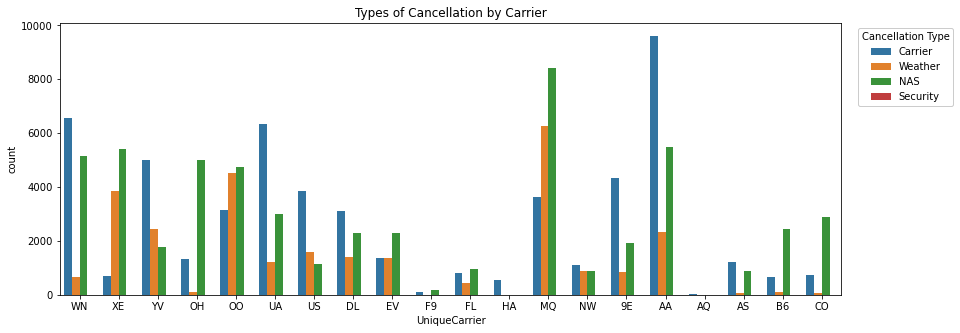

In [130]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(14,5))
#Plot the types of cancellation by carrier
ax=sb.countplot(data = df_flights, x = 'UniqueCarrier', hue = 'CancellationCode')
ax.legend((['Carrier', 'Weather', 'NAS', 'Security']), loc = 1, bbox_to_anchor = (1.15, 1.0), framealpha = 1, title='Cancellation Type')
plt.title('Types of Cancellation by Carrier');

Some of the big, well known carriers, such as American(AA) and United(UA) tend to have a proptionately higher number of Carrier cancellations. Otherwise, there is not a clear pattern that sticks out.

Next let's explore cancellations by origin airport. Are there any that are more or less prone to cancellations?

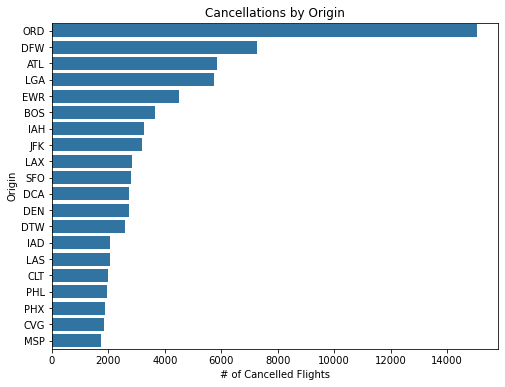

In [127]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))

# Get sorted frame of cancelations by origin
cancel_by_origin = df_flights.groupby('Origin')['Cancelled'].sum().sort_values(ascending=False).head(20)

# Plot total number of cancellations by origin
sb.barplot(y=cancel_by_origin.index,
           x=cancel_by_origin,
           color=base_color)
plt.title('Cancellations by Origin')
plt.xlabel('# of Cancelled Flights');

Here we are justing look at totals, but we can see that Chicago O'Hare has by far the largest amount, followed by Dallas and Atlanta. Let's normalize by the total number of flights and see if there are differences.

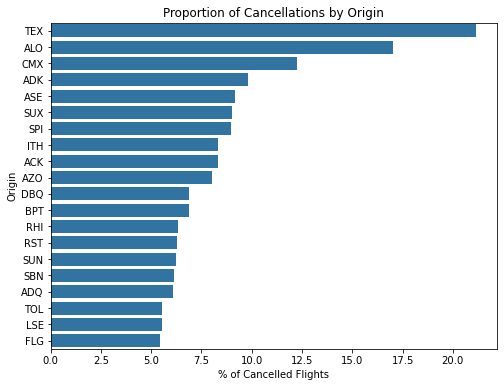

In [128]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))

# Get sorted frame of cancelations by origin
can_by_orig = df_flights.groupby('Origin')['Cancelled'].sum()
tot_by_orig = df_flights.groupby('Origin')['Cancelled'].count()
prop_by_orig = (100*can_by_orig/tot_by_orig).sort_values(ascending=False).head(20)

# Plot proportionate number of cancellations by carrier
sb.barplot(y=prop_by_orig.index,
           x=prop_by_orig,
           color=base_color)
plt.title('Proportion of Cancellations by Origin')
plt.xlabel('% of Cancelled Flights');

We see quite a difference when we look at an origin's proportion of cancelled flights. Most of these are small regional airports. Telluride (TEX) tops the list with a whopping more than 20% of its flights being cancelled. Assuming that these smaller airports might not be equipped with the same sort of equipment that larger airports have (advanced radar, de-icing stations, etc.), it makes sense that they might be more cancellation prone. We'd need to investigate further before stating this definitively, however.

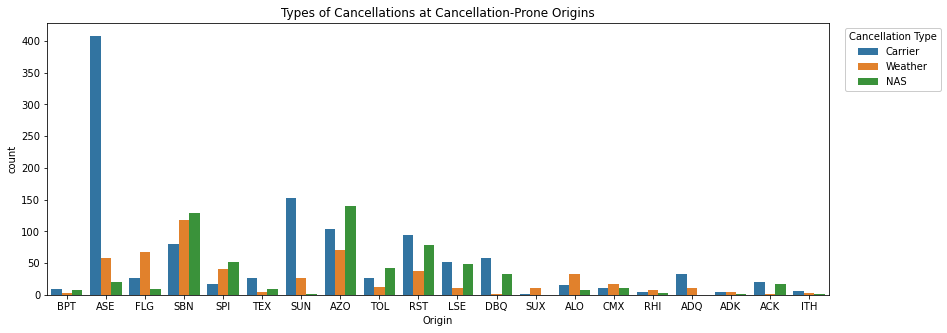

In [138]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(14,5))
# Trim dataset to those with origins that have a high prop of cancellations
top_can_orig = df_flights[df_flights['Origin'].isin(prop_by_orig.index)]
#Plot the types of cancellation by origin
ax=sb.countplot(data = top_can_orig, x = 'Origin', hue = 'CancellationCode')
ax.legend((['Carrier', 'Weather', 'NAS', 'Security']), loc = 1, bbox_to_anchor = (1.15, 1.0), framealpha = 1, title='Cancellation Type')
plt.title('Types of Cancellations at Cancellation-Prone Origins');

What really sticks out here is that Aspen (ASP) has a very high proportion of Carrier cancellations. Also, some while weather cancellations have generally not been high in proportion to Carrier and NAS cancellations, in certain locations they actually predominate (i.e. Grand Canyon(FLG), Waterloo, Iowa (ALO), and Hancock, Michigan (CMX).

### Delays

Next let's look at the proportion of delays per day of week. We're going to limit our analysis to Arrival Delays, which have a greater impact to travelers. For example, if there is a departure delay, but the flight still arrives on time, there is little impact in terms of missed connections, etc.

As I mentioned above, it is a general rule of thumb that a flight isn't officially delayed until at least 15 minutes have passed beyond the scheduled time, so we'll focus our attention on those. Frankly, investigating the trends of one minute delays doesn't really have much significance. Also, we'll agains be dividing by the total number of flights per day of week to take into account the differences in the number of flights.

In [150]:
# Construct a set of flights that have arrival delays greater than 15 minutes
df_delayed_flights = df_flights[df_flights['ArrDelay']>=15]

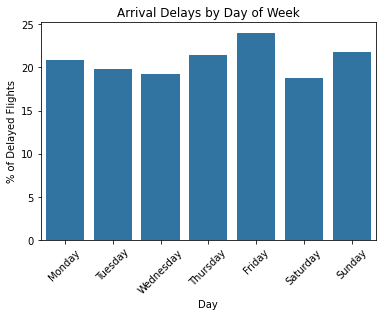

In [127]:
# Get total # of delays and total number of flights per day
delayed_by_day = df_delayed_flights.groupby('DayOfWeek')['ArrDelay'].count()
total_by_day = df_flights.groupby('DayOfWeek')['ArrDelay'].count()

# Plot % of delays by day of week
sb.barplot(x=delayed_by_day.index,
           y=100*delayed_by_day/total_by_day,
           color=base_color)
plt.title('Arrival Delays by Day of Week')
plt.ylabel('% of Delayed Flights')
plt.xlabel('Day')
plt.xticks(np.arange(0,7,1), days_of_week, rotation=45);

Similar to what we saw with cancellations, Friday seems to be the day with the most delays. Saturday has the lowest percentage of delays. Another item to note is that high level of delays (over 15% each day) in general.

Next let's look at delay types per day of week. 

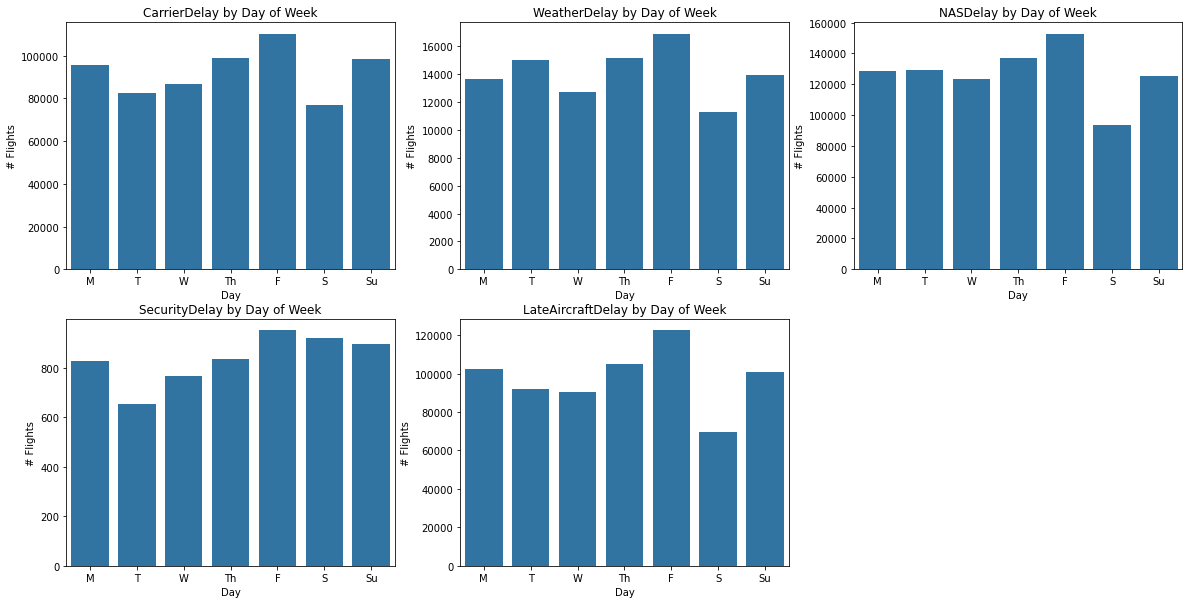

In [133]:
# Set figure size
plt.figure(figsize=(20,10))
# Constuct list of columns to plot
delay_types = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Plot each of our "delay type" columns
for i in range(len(delay_types)):
    plt.subplot(2, 3, i+1)
    # Plot the number of flights where the given column is greater than 0
    # This indicates whether or not it was "flagged" as a delay reason
    # Remember these are not mutually exlusive, a flight can have values in more than one of these columns
    delayed_by_day = df_delayed_flights[df_delayed_flights[delay_types[i]]>0].groupby('DayOfWeek')[delay_types[i]].count()
    sb.barplot(x=delayed_by_day.index,
               y=delayed_by_day,
               color=base_color)
    plt.title('{} by Day of Week'.format(delay_types[i]))
    plt.ylabel('# Flights')
    plt.xlabel('Day')
    plt.xticks(np.arange(0,7,1), dow_short);

There doesn't appear to be a real pattern here other than there are more delays on days when there are more flights. There is one exception: Saturday, which has the fewest delays of each type (it also has the fewest flights) has the second highest number of security delays. It might be interesting to explore whether or not this is due to the fact that fewer people may be traveling for business on that day and they may be less savy when with the necessary identification and security procedures. Or could it possibly be because less people are flying, which gives agents more time to check passengers. Either question is outside the scope of this project, but it is interesting to note.

Let's look at delays by month.

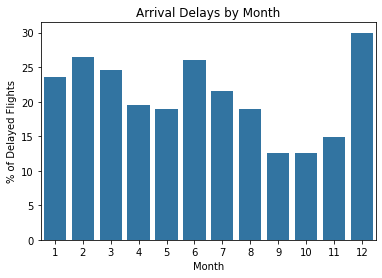

In [138]:
# Get total # of delays and total number of flights per mont
delayed_by_mo = df_delayed_flights.groupby('Month')['ArrDelay'].count()
total_by_mo = df_flights.groupby('Month')['ArrDelay'].count()

# Plot % of delays by month
sb.barplot(x=delayed_by_mo.index,
           y=100*delayed_by_mo/total_by_mo,
           color=base_color)
plt.title('Arrival Delays by Month')
plt.ylabel('% of Delayed Flights')
plt.xlabel('Month');

Again, there are a number of similarities with what we observed with cancellations per month. There are generally more delays in the winter, however, there are also more in the summer, as well. It's the spring and fall that see the fewest delays. Let's check delay types to see if we can understand why.

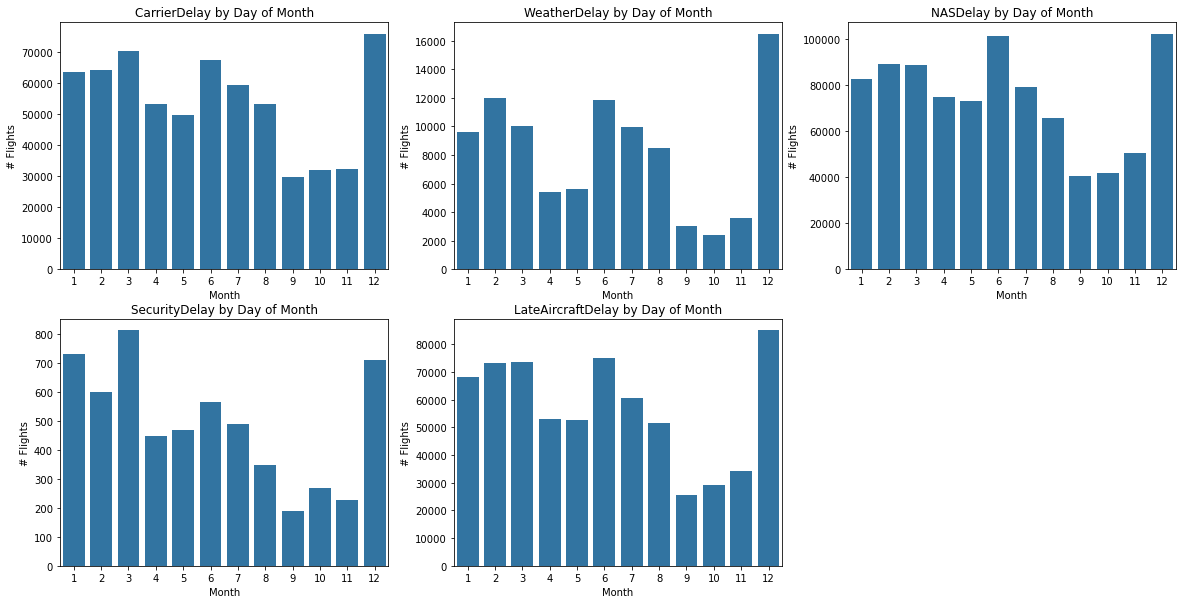

In [140]:
# Set figure size
plt.figure(figsize=(20,10))

# Plot each of our "delay type" columns
for i in range(len(delay_types)):
    plt.subplot(2, 3, i+1)
    # Plot the number of flights where the given column is greater than 0
    # This indicates whether or not it was "flagged" as a delay reason
    # Remember these are not mutually exlusive, a flight can have values in more than one of these columns
    delayed_by_mo = df_delayed_flights[df_delayed_flights[delay_types[i]]>0].groupby('Month')[delay_types[i]].count()
    sb.barplot(x=delayed_by_mo.index,
               y=delayed_by_mo,
               color=base_color)
    plt.title('{} by Day of Month'.format(delay_types[i]))
    plt.ylabel('# Flights');

Here we can see that carrier, weather and late aircraft delays follow the pattern we saw for our totals. It makes sense that there are more weather-related delays (and hence more late-aircraft delays) in the winter (snow) and summer (thunderstorms).

Next, let's look at our delays in terms of departure times. Which departure times are more prone to having your flight arrive late?

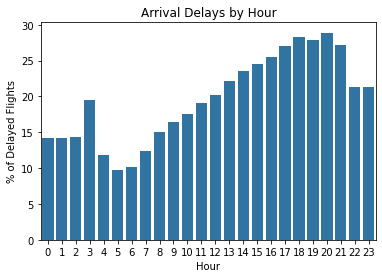

In [144]:
# Get total # of delays and total number of flights per departure hour
delayed_by_h = df_delayed_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['ArrDelay'].count()
total_by_h = df_flights.groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))['ArrDelay'].count()

# Plot % of delays by month
ax=sb.barplot(x=delayed_by_h.index,
           y=100*delayed_by_h/total_by_h,
           color=base_color)
plt.title('Arrival Delays by Hour')
plt.ylabel('% of Delayed Flights')
plt.xlabel('Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

The percentage of delayed flights increases by the hour from about 5am to 10pm. This could be a compounding effect, where delays cause delays for dependent aircraft (i.e. late aircraft delays.) Let's take a look at delay types per hour.

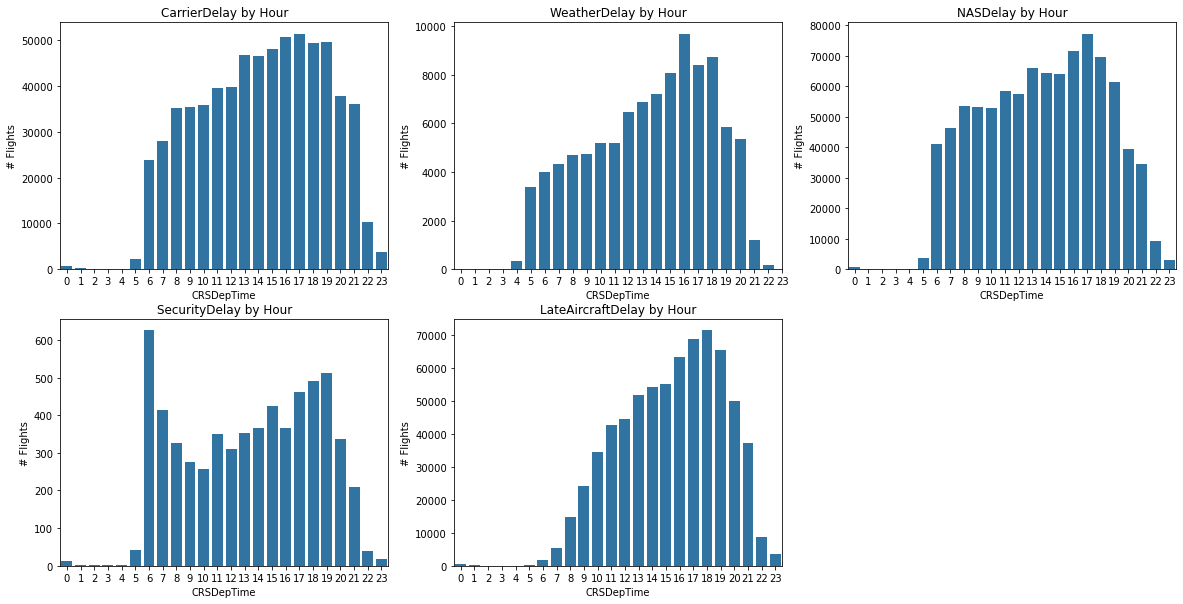

In [156]:
# Set figure size
plt.figure(figsize=(20,10))

# Plot each of our "delay type" columns
for i in range(len(delay_types)):
    plt.subplot(2, 3, i+1)
    # Plot the number of flights where the given column is greater than 0
    # This indicates whether or not it was "flagged" as a delay reason
    # Remember these are not mutually exlusive, a flight can have values in more than one of these columns
    delayed_by_h = df_delayed_flights[df_delayed_flights[delay_types[i]]>0].groupby(df_flights['CRSDepTime'].astype('timedelta64[h]'))[delay_types[i]].count()
    ax=sb.barplot(x=delayed_by_h.index,
               y=delayed_by_h,
               color=base_color)
    plt.title('{} by Hour'.format(delay_types[i]))
    plt.ylabel('# Flights')
    ticks=np.arange(0,24,1)
    plt.xticks(ticks=ticks,labels=ticks);

The various delay types have similar distributions, increasing from the morning until the peak in the early evening and then dop off. There is a curious spike in security delays at around 6am, however.

Next, let's look at delays by airline.

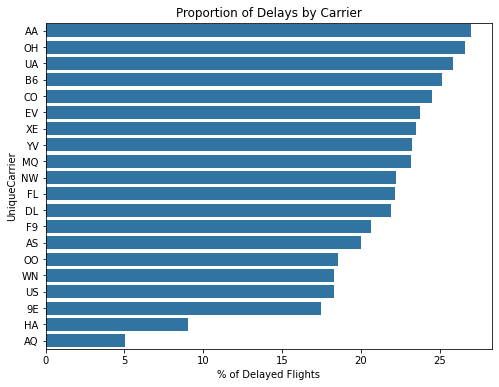

In [152]:
# Get total # of delays and total number of flights per day
delay_by_carr = df_delayed_flights.groupby('UniqueCarrier')['ArrDelay'].count()
total_by_carr = df_flights.groupby('UniqueCarrier')['ArrDelay'].count()
# Calculate and sort proportion of cancellations by carrier
prop_del_by_carr = 100*delay_by_carr/total_by_carr
sorted_props = prop_del_by_carr.sort_values(ascending=False)
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))

# Plot total number of delays by carrier
sb.barplot(y=sorted_props.index,
           x=sorted_props,
           color=base_color)
plt.title('Proportion of Delays by Carrier')
plt.xlabel('% of Delayed Flights');

American airlines tops the list with more than a quarter of their flights being delayed! Let's look at why this may be by taking a look at delay types.

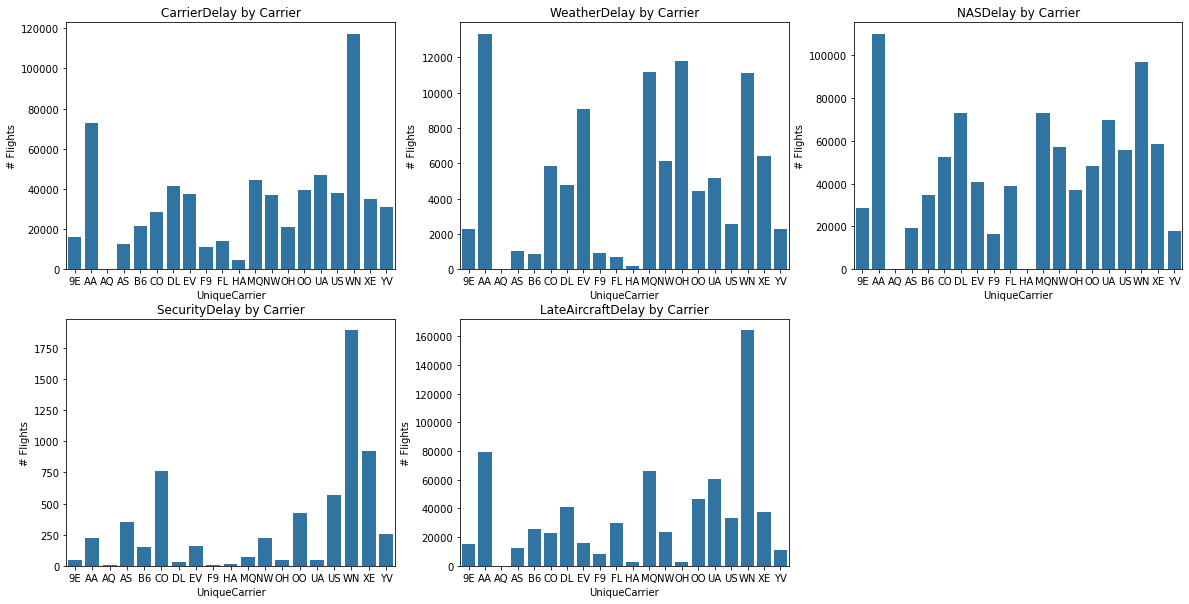

In [166]:
# Set figure size
plt.figure(figsize=(20,10))

# Plot each of our "delay type" columns
for i in range(len(delay_types)):
    plt.subplot(2, 3, i+1)
    # Plot the number of flights where the given column is greater than 0
    # This indicates whether or not it was "flagged" as a delay reason
    # Remember these are not mutually exlusive, a flight can have values in more than one of these columns
    delayed_by_mo = df_delayed_flights[df_delayed_flights[delay_types[i]]>0].groupby('UniqueCarrier')[delay_types[i]].count()
    sb.barplot(x=delayed_by_mo.index,
               y=delayed_by_mo,
               color=base_color)
    plt.title('{} by Carrier'.format(delay_types[i]))
    plt.ylabel('# Flights');

Keep in mind that these are totals of each delay type per airline, but if we look at American in particular, we see that their highest number of flight delays are a result of Weather and NAS delays. What is interesting to observe here is that each type seems to have its own unique distribution, i.e. there doesn't seem to be similarity across types and the number per respective airline.

Next, let's take a look at where most delays originate. Again, we're not looking at departure delays, but arrival delays since arriving late has more impact on customers.

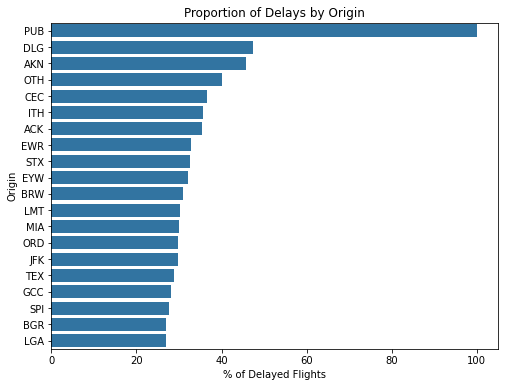

In [155]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))

# Get sorted frame of delays by origin
del_by_orig = df_delayed_flights.groupby('Origin')['ArrDelay'].count()
tot_by_orig = df_flights.groupby('Origin')['ArrDelay'].count()
prop_by_orig = (100*del_by_orig/tot_by_orig).sort_values(ascending=False).head(20)

# Plot proportionate number of cancellations by carrier
sb.barplot(y=prop_by_orig.index,
           x=prop_by_orig,
           color=base_color)
plt.title('Proportion of Delays by Origin')
plt.xlabel('% of Delayed Flights');

Similar to what we saw with cancellations, smaller regional airports tend to have a higher proportion of delays. Still, the result for the Pueblo, Colorado airport, in which almost all flights have reported a delay, is suprising.

Next, let's look at delay types by origin. Instead of looking at totals, we will plot the top 10 origins for each delay type by proportion of flights with that type of delay. Here it makes sense to plot proportions and look at the top 10 since there are too many airports to view at one time.

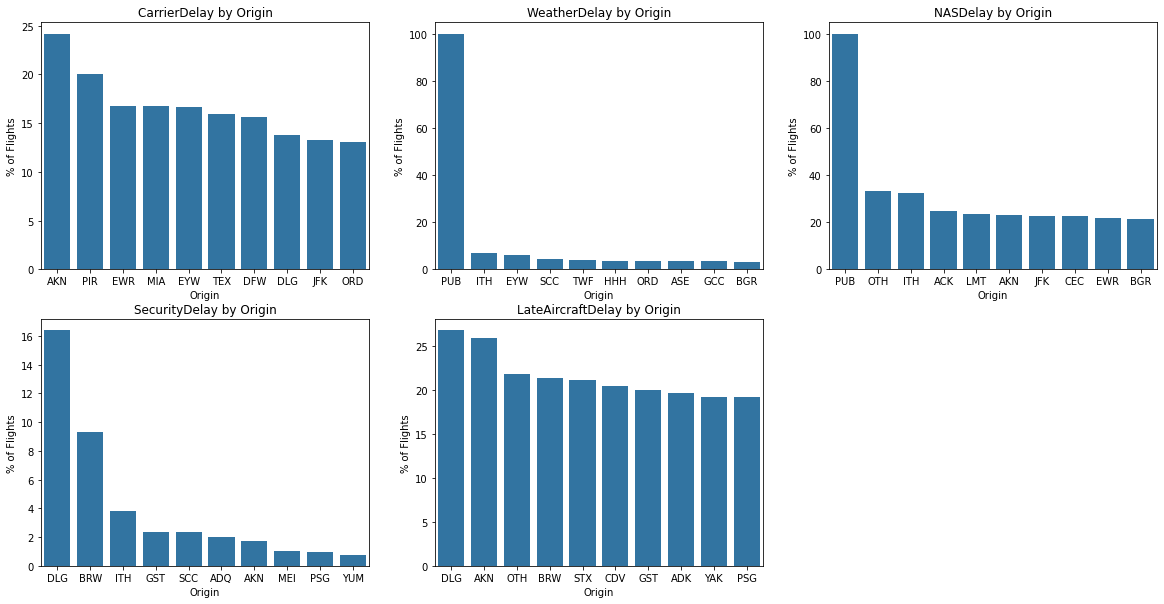

In [173]:
# Set figure size
plt.figure(figsize=(20,10))

# Plot each of our "delay type" columns
for i in range(len(delay_types)):
    plt.subplot(2, 3, i+1)
    # Plot the number of flights where the given column is greater than 0
    # This indicates whether or not it was "flagged" as a delay reason
    # Remember these are not mutually exlusive, a flight can have values in more than one of these columns
    delayed_by_o = (100*df_delayed_flights[df_delayed_flights[delay_types[i]]>0].groupby('Origin')[delay_types[i]].count()/tot_by_orig).sort_values(ascending=False).head(10)
    sb.barplot(x=delayed_by_o.index,
               y=delayed_by_o,
               color=base_color)
    plt.title('{} by Origin'.format(delay_types[i]))
    plt.ylabel('% of Flights');

Here we can see that each delay type has a different set of airports in its list. We can see that the Pueblo airport has a vastly higher proportion of weather delays than other airports. That aiport also has a much higher proportion of NAS delays compared to others. The Dillingham Airport in Alaska has a much higher percentage of security delays than other airports. Also here we see that smaller, regional airports tend to dominate when we look at the relative proportion of delays per type.

Finally, let's take a look at how all of these various features concerning delays are related to each other. So far, we've been treating all of our delay features as if they were booleans: true if positive, false if negative. But these features actually hold the number of minutes for a given delay types.

In [185]:
df_flights[df_flights['Origin']=='PUB']

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3701794,2008,7,8,2,0 days 16:55:00,0 days 17:04:00,XE,104,70.0,45.0,PUB,COS,False,NaN,False,0.0,45.0,25.0,0.0,0.0
3702095,2008,7,14,1,0 days 13:22:00,0 days 13:31:00,XE,117,78.0,9.0,PUB,COS,False,NaN,False,0.0,9.0,69.0,0.0,0.0


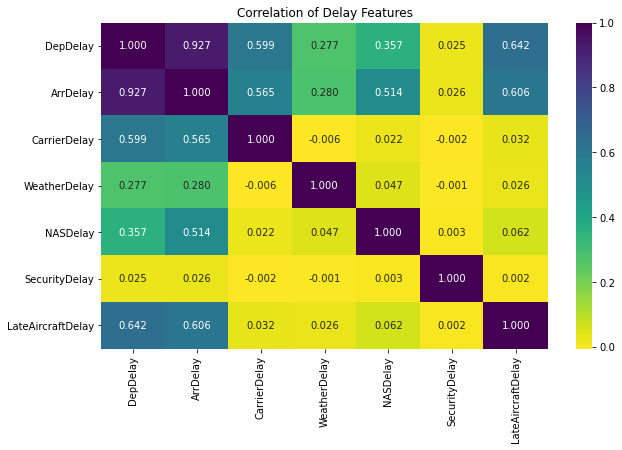

In [183]:
plt.figure(figsize=(10, 6))
sb.heatmap(df_flights[['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].corr(), annot=True, fmt='.3f', cmap='viridis_r');
plt.title('Correlation of Delay Features');

Right away we see that `DepDelay` and `ArrDelay` are very closely positively correlated. `LateAircraftDelay` and `CarrierDelay` seem to be somewhat positively correlated to both `DepDelay` and `ArrDelay`, while `WeatherDelay` and `NASDelay` a little less positively correlated. `SecuityDelay` does not seem to have much correlation to `DepDelay` and `ArrDelay`. All of the delay types have little correlation to one another.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

- Cancelled vs. Month: It is clear that there are more cancellations in the winter months.
- With other values of time, i.e. scheduled departure time and day of week, the relationship is less clear.
- Cancellation Type vs. Scheduled Departure Time: "Weather" cancellation types seem to be normally distributed with the time of departure, peaking in the early evening, as opposed to the other three cancellation types, which seem relatively consistent over departure time.
- Cancellation Type vs. Unique Carrier: Some of the big, well known carriers, such as American(AA) and United(UA) tend to have a proptionately higher number of Carrier cancellations.
- In some cases (Cancelled vs. Day of Week, Cancelled vs. Scheduled Departure Time, and Cancelled vs. Origin) it was very important to normalize our data (divide by the total number of flights). For example, if we plot the top 20 origin airports for cancellations, we'll see the biggest airports. But if we plot the proportion of cancellations per origin airport, we will get a completely different set which includes smaller, regional airports. This may be because smaller airports may be less equiped to handle issues, but we'd need to confirm this with more data.  

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?



## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!